Analysis of pupil data
======================

There are many valid approaches to the analysis of pupillometry data, but the optimal approach will depend on the type of experiment being run and the research question in mind. [Kelbsch et al. (2019)](https://www.frontiersin.org/articles/10.3389/fneur.2019.00129/full) provide an informative view on standards in pupillometry, and there are [some](https://github.com/samhforbes/PupillometryR) [great](https://github.com/beOn/cili) [examples](https://github.com/ihrke/pypillometry) of community-developed packages for streamlining pupillometry data analysis. Whilst it is always worth exploring the wider options that are available, *PyPlr* includes a set of pandas-reliant (you won't regret [learning pandas!](https://bitbucket.org/hrojas/learn-pandas/src/master/)) scripting tools for implementing a standard data processing pipeline that is optimised to work with some of the idiosynchrasies of Pupil Labs data. So far we have found these tools to be adequate for analysing our own data, but we welcome suggestions for improvements. 

Here we explore the application of our analysis tools on an example data set. A typical pipeline for data analysis looks like this:

- Export a recording with Pupil Player
- Data loading
- Preprocessing (dealing with blinks, smoothing, etc.)
- Trial extraction
- Summarising

Check out [this](https://github.com/pupil-labs/pupil-tutorials/blob/master/01_load_exported_data_and_visualize_pupillometry.ipynb) tutorial first...

Export with Pupil Player
------------------------

The first step in our pipeline is to export the data using [Pupil Player](https://docs.pupil-labs.com/core/software/pupil-player/), making sure the required plugins (e.g., Annotation Player plugin) are enabled. Currently this must be done individually for each recording. Below is printed the file structure of a typical recording after export (more info on recording format [here](https://docs.pupil-labs.com/developer/core/recording-format/#recording-format)).

In [1]:
import sys
sys.path.insert(0,'../')
from pyplr import utils

rec_dir = '/Users/jtm/OneDrive - Nexus365/protocols/pipr_protocol/JTM'
utils.print_file_structure(rec_dir)

JTM/
    .DS_Store
    annotation.pldata
    annotation_player.pldata
    annotation_player_timestamps.npy
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    analysis/
        plr_extraction.png
        plr_metrics.csv
        plr_overall_metrics.png
        processed.csv
        pupil_processing.png
    exports/
        000/
            annotations.csv
            export_info.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4
            world_timestamps.csv
            world_timestamps

Load exported data
------------------

Now we can set up some constants and use `pyplr.utils` to get things moving. `new_subject(...)` returns a dictionary with the root directory, recording id, data directory and a newly made output directory for the analysis results. Then, passing the data directory to `load_pupil(...)`, we load the *pupil_positions.csv* exported data with the specified columns.

In [2]:
import sys
sys.path.insert(0,'../')
from pyplr import utils

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

# Load pupil data
samples = utils.load_pupil(
    s['data_dir'], eye_id='best', cols=use_cols)

samples

************************************************************
*************************** JTM ****************************
************************************************************
Loaded 48552 samples


,eye_id,confidence,diameter,method,diameter_3d
pupil_timestamp,,,,,
85838.895658,1,0.977211,50.102968,3d c++,6.105771
85838.903656,1,0.997867,50.037086,3d c++,6.099682
85838.911644,1,0.998295,49.702628,3d c++,6.060059
85838.919551,1,0.997833,49.968637,3d c++,6.093759
85838.927504,1,0.998183,49.883191,3d c++,6.084404
...,...,...,...,...,...
86246.730916,1,0.818574,56.684975,3d c++,6.966634
86246.739307,1,0.947873,56.824819,3d c++,6.983579
86246.746889,1,0.969337,57.176728,3d c++,7.027931


Preprocessing
-------------

Preprocessing pupillometry data is relatively straight-forward and typically involves dealing with signal loss due to eye blinks and smoothing out any high frequency noise. There are [sophisticated algorithms](https://osf.io/jyz43/) for detecting blinks in a pupil time course, but Pupil Player has its own [Blink Detection](https://docs.pupil-labs.com/core/software/pupil-capture/#blink-detection) plugin that detects blinks based on rapid changes in the [confidence metric](https://docs.pupil-labs.com/core/terminology/#confidence). Whilst you can export these blink events and use the timestamps to index and mask the pupil timecourse, we find that it is more effective to mask the pupil data using thresholds on the first derivative and confidence metric. Then, we can follow up with linear interpolation and smoothing.

<AxesSubplot:title={'center':'Butterworth filtered'}, xlabel='pupil_timestamp', ylabel='Pupil diameter'>

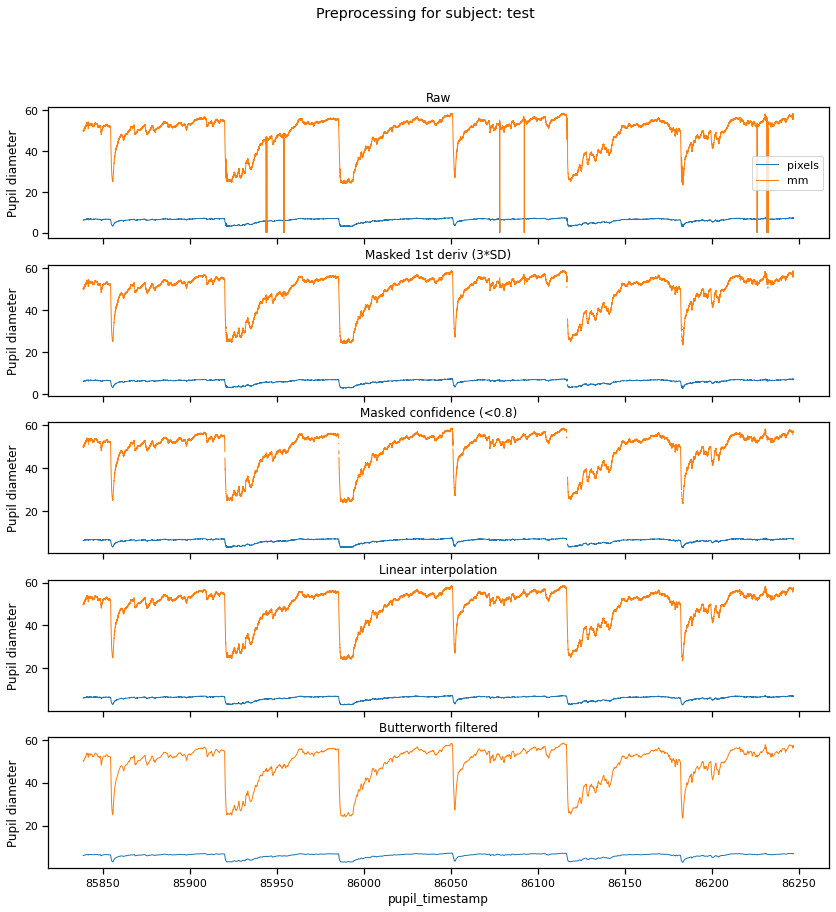

In [3]:
import seaborn as sns
sns.set_context('notebook', rc={"lines.linewidth": 1})
from pyplr import graphing
from pyplr import preproc

# sampling rate of the data
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
f, axs = graphing.pupil_preprocessing(nrows=5, subject='test')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels', 'mm'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth  
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3, cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='Butterworth filtered', ax=axs[4], legend=False)



Extraction
----------

Having cleaned the timecourse, we now need to extract our events of interest. This requires the annotation events sent during the recording, which contain the timestamps needed for extraction. The annotations can be loaded with ``utlis.load_annotations(...)``.

In [4]:
events = utils.load_annotations(s['data_dir'])
events

Loaded 6 events


,index,label,duration,color,creation_time,creator,protocol,pulse_duration,pulse_spec
timestamp,,,,,,,,,
85854.348667,1835,LIGHT_ON,NaN,red,2020-11-10 09:39:10.888989,jtm,pulse,1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1979]"
85919.820362,9629,LIGHT_ON,NaN,blue,2020-11-10 09:39:10.882007,jtm,pulse,1000,"[0, 0, 0, 2500, 0, 0, 0, 0, 0, 0]"
85985.280630,17422,LIGHT_ON,NaN,blue,2020-11-10 09:39:10.882007,jtm,pulse,1000,"[0, 0, 0, 2500, 0, 0, 0, 0, 0, 0]"
86050.768628,25217,LIGHT_ON,NaN,red,2020-11-10 09:39:10.888989,jtm,pulse,1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1979]"
86116.228025,33008,LIGHT_ON,NaN,blue,2020-11-10 09:39:10.882007,jtm,pulse,1000,"[0, 0, 0, 2500, 0, 0, 0, 0, 0, 0]"
86181.688172,40801,LIGHT_ON,NaN,red,2020-11-10 09:39:10.888989,jtm,pulse,1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1979]"


Now all we need to do is pass our samples and events to the ``utils.extract(...)`` function, along with some parameters defining the number of samples we want to extract and how much we want to offset the data relative to the event. Here we are extracting 65 second epochs and offsetting by 5 seconds.

In [5]:
from pyplr.utils import extract

DURATION = 7800
ONSET_IDX = 600

# Extract the events and their baselines
ranges = extract(samples, 
                 events, 
                 offset=-ONSET_IDX, 
                 duration=DURATION, 
                 borrow_attributes=['color'])

baselines = ranges.mean(level=0)

# New columns for percent signal change
ranges['diameter_pc'] = (
    ranges.diameter / baselines.diameter - 1).values * 100
ranges['diameter_3dpc'] = (
    ranges.diameter_3d / baselines.diameter_3d - 1).values * 100

ranges

Extracted ranges for 6 events


eye_id  confidence   diameter  method  diameter_3d  interpolated  \
event onset                                                                     
0     0         1.0    0.998989  48.404937  3d c++     5.990967             0   
      1         1.0    0.998972  48.436117  3d c++     5.994949             0   
      2         1.0    0.999134  48.469848  3d c++     5.999237             0   
      3         1.0    0.998426  48.505896  3d c++     6.003802             0   
      4         1.0    0.998895  48.544031  3d c++     6.008612             0   
...             ...         ...        ...     ...          ...           ...   
5     7795      1.0    0.922093  54.375155  3d c++     6.707360             0   
      7796      1.0    0.977674  54.338056  3d c++     6.703963             0   
      7797      1.0    0.933031  54.304633  3d c++     6.701016             0   
      7798      1.0    0.970404  54.274990  3d c++     6.698505             0   
      7799      1.0    0.903852  54.249187  3d c++     6.696413             0   

                 orig_idx color  diameter_pc  diameter_3dpc  
event onset                                                  
0     0      85849.311553   red    -5.101817      -5.115773  
      1      85849.319757   red    -5.040688      -5.052716  
      2      85849.327708   red    -4.974559      -4.984796  
      3      85849.335675   red    -4.903885      -4.912503  
      4      85849.343669   red    -4.829121      -4.836323  
...                   ...   ...          ...            ...  
5     7795   86242.127040   red     8.869837       8.516100  
      7796   86242.135026   red     8.795558       8.461144  
      7797   86242.142965   red     8.728638       8.413458  
      7798   86242.150957   red     8.669287       8.372836  
      7799   86242.162996   red     8.617624       8.338998  

[46800 rows x 10 columns]

``utils.extract(...)`` returns a pandas DataFrame with a hierarchichal index. This is how we can plot the average of all trials.

<AxesSubplot:xlabel='onset'>

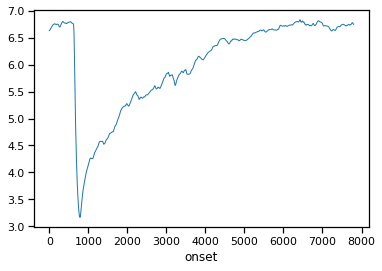

In [6]:
ranges.mean(level=1)['diameter_3d'].plot()

Introduce plr module.

Parametrisation
---------------

A PLR can be described in terms of paremeters relating to time, velocity and acceleration. Once you have an array of data representing a pupil's response to light, be it from a single trial or an average of multiple trials, simply pass it to `pyplr.plr.PLR` along with some basic parameters.

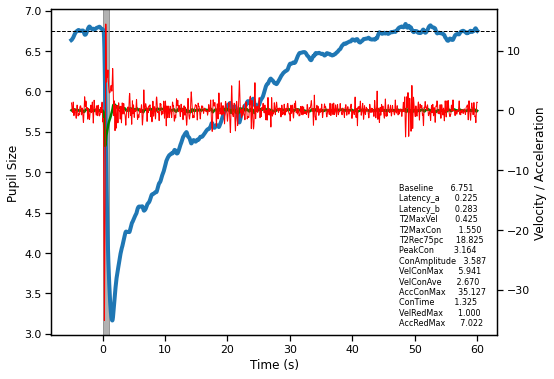

In [7]:
from pyplr.plr import PLR
import seaborn as sns
sns.set_context('notebook')
plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(plr, sample_rate=SAMPLE_RATE, onset_idx=ONSET_IDX, stim_duration=1)
fig = plr.plot()

In [8]:
plr.parameters()

,value
Baseline,6.751031
Latency_a,0.225000
Latency_b,0.283333
T2MaxVel,0.425000
T2MaxCon,1.550000
T2Rec75pc,18.825000
PeakCon,3.164023
ConAmplitude,3.587008
VelConMax,5.940593
VelConAve,2.670336
